In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

### Plot Gaussian

In [2]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, ax, weights = None):
    K = int(mus.shape[0])
    #K = 2
    if weights is None:
        weights = np.ones(K)/K
    
    for k in range(K):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=4.*np.sqrt(val[0]), height=4.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        #ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    return

### Gaussian Variational Approximations 

### Generate Data

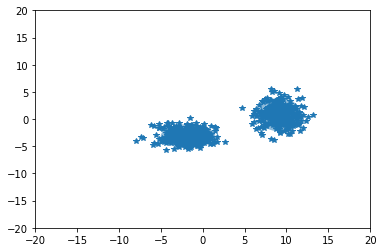

In [3]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K = 4
K_true = 2
N = 300

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
samples = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

fig,ax = plt.subplots()
plot_gaussian(mus_true,sigmas_true,ax)
plt.plot(samples[:,0],samples[:,1],'*')

In [4]:
print sigmas_true

[[[2.66328337 0.        ]
  [0.         1.21306575]]

 [[1.69876721 0.        ]
  [0.         2.35833788]]]


In [5]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import dirichlet, invwishart, wishart
from tensorflow_probability import distributions as tfd
import tensorflow as tf

sess = tf.InteractiveSession()

/home/teguh/.local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/teguh/.local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/teguh/.local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/teguh/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
/home/teguh/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dt


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
pis_unnormalized = tf.Variable(tf.random_uniform((K,1)),tf.float32)
pis_sum = tf.reduce_sum(tf.exp(pis_unnormalized))
pis = tf.exp(pis_unnormalized)/pis_sum

mus = tf.Variable(samples[np.random.choice(range(len(samples)),size=K)],dtype=tf.float32)

#L = tf.Variable(tf.random_uniform([K, D*(D+1)/2]))
L = tf.Variable(tf.stack([tf.eye(D) for i in range(K)]))

num_batch = 50
data = tf.placeholder(tf.float32, shape=[num_batch,D])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def log_gaussian_prior(mu, mu_0 = tf.zeros(D), sigma_0 = tf.eye(D)):
    return tfd.MultivariateNormalFullCovariance(loc=mu_0, covariance_matrix = sigma_0).log_prob(mu)
    
def log_dirichlet_prior(pis, alphas = tf.ones(K)/K):
    return tfd.Dirichlet(alphas).log_prob(pis[:,0])
    
def log_wishart_prior(sigma, df = D, scale = tf.eye(D)):
    return tfd.Wishart(df,scale).log_prob(sigma)

def log_posterior(pis, mus, L, data):
    '''sigmas = []
    for k in range(pis.shape[0]):
        sigma = tfd.fill_triangular(L[k])
        sigmas.append(sigma)
        
    sigmas = tf.stack(sigmas)'''
    
    GMM = tfd.Mixture(cat = tfd.Categorical(probs = pis[:,0]), \
        components=[tfd.MultivariateNormalTriL(loc=mus[k], scale_tril=L[k]) for k in range(pis.shape[0])])
    
    post = tf.reduce_sum(GMM.log_prob(data))
    
    for k in range(pis.shape[0]):
        post += log_gaussian_prior(mus[k])
        #post += log_wishart_prior(tf.matmul(sigmas[k], tf.transpose(sigmas[k])))

    post += log_dirichlet_prior(pis)    
    return post

In [12]:
post = log_posterior(pis, mus, L, data)

In [13]:
optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(-post,var_list=[pis_unnormalized,mus,L])

Instructions for updating:
Use tf.cast instead.


In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
from IPython.display import clear_output

In [16]:
for i in range(1000):
    np.random.shuffle(samples)
    _,val = sess.run([train,-post], feed_dict={data:samples[0:num_batch]})
    print i,val

0 446.66495
1 410.79434
2 370.06485
3 386.6216
4 374.83163
5 379.29984
6 362.63696
7 361.27975
8 395.22513
9 412.1309
10 351.8219
11 324.00394
12 327.87186
13 370.36484
14 345.8695
15 360.4763
16 351.3972
17 347.56827
18 347.07397
19 366.69482
20 359.928
21 358.4318
22 382.94885
23 303.84167
24 374.26376
25 338.18988
26 356.19467
27 341.37357
28 328.2187
29 336.8157
30 320.3192
31 315.7721
32 338.47137
33 325.4111
34 313.62033
35 311.61014
36 305.13498
37 321.3658
38 309.92386
39 297.76035
40 318.08792
41 311.92627
42 307.13
43 305.83157
44 300.0392
45 288.29654
46 323.1635
47 301.88217
48 293.02542
49 289.72974
50 287.37616
51 308.47318
52 311.36578
53 290.7779
54 282.56985
55 290.94797
56 290.5921
57 293.0479
58 300.98462
59 318.7918
60 318.2401
61 297.26993
62 293.25735
63 286.88873
64 280.35098
65 287.71353
66 292.7095
67 293.4436
68 290.0551
69 309.21484
70 276.6398
71 296.04373
72 300.05692
73 287.96786
74 299.1346
75 287.05032
76 280.8625
77 291.3969
78 295.6686
79 290.78424
80 

609 255.37222
610 267.08542
611 264.86517
612 272.85608
613 272.63977
614 275.4652
615 273.02133
616 269.5698
617 251.69797
618 271.53778
619 265.87125
620 266.94537
621 263.7981
622 255.14581
623 263.29312
624 256.40573
625 265.56918
626 247.69398
627 263.54193
628 260.12723
629 260.77307
630 266.0309
631 268.90546
632 261.02045
633 267.0656
634 256.33316
635 252.01355
636 267.50165
637 268.14175
638 258.4157
639 248.85637
640 259.69818
641 254.44453
642 274.89703
643 258.24765
644 250.566
645 266.14365
646 270.16672
647 273.46442
648 259.01422
649 260.97156
650 262.37875
651 246.50308
652 256.31177
653 258.7422
654 266.19452
655 262.54617
656 255.31319
657 266.67056
658 261.4503
659 273.47977
660 250.89555
661 265.21976
662 253.34276
663 256.57104
664 260.02856
665 255.04549
666 274.37555
667 256.0973
668 254.24698
669 266.7059
670 274.67807
671 252.29912
672 267.9179
673 267.06693
674 277.10657
675 253.25377
676 261.56326
677 255.99316
678 251.33618
679 266.53928
680 255.65205
681 2

In [125]:
with sess.as_default():
    print mus.eval()
    print pis.eval()

    sigma_full = []
    for sigma in L.eval():
        #sigma = tfd.fill_triangular(sigma).eval()
        sigma_full.append((np.matmul(sigma,(sigma.T))))
    print sigma_full

[[-5.8286057  4.1443515]
 [-4.968001   3.443268 ]
 [-6.8453655 -4.047155 ]
 [-5.4579034 -5.369244 ]]
[[0.03822066]
 [0.43824804]
 [0.05355451]
 [0.46997675]]
[array([[0.04420881, 0.02668647],
       [0.02668647, 0.5917294 ]], dtype=float32), array([[0.4453439 , 0.00841234],
       [0.00841234, 0.7710659 ]], dtype=float32), array([[3.2471755 , 0.50171065],
       [0.50171065, 2.0279996 ]], dtype=float32), array([[2.7869747 , 0.25865647],
       [0.25865647, 2.2278626 ]], dtype=float32)]


In [126]:
print mus_true
print sigmas_true

[[-5.72297043 -5.30105816]
 [-5.08354442  3.52367427]]
[[[2.88297417 0.        ]
  [0.         2.56929333]]

 [[0.47249757 0.        ]
  [0.         0.8375061 ]]]


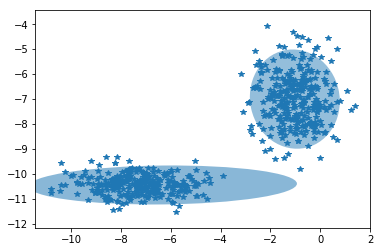

In [111]:
with sess.as_default():
    fig,ax = plt.subplots()
    plot_gaussian(mus.eval(),sigma_full,ax,pis.eval())
    plt.plot(samples[:,0],samples[:,1],'*')
    plt.axis('equal')

In [50]:
sess.close()

In [149]:
#use sklearn
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

gmm.fit(samples)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

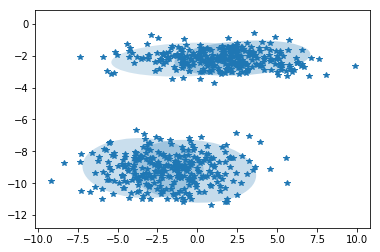

In [150]:
with sess.as_default():
    fig,ax = plt.subplots()
    plot_gaussian(gmm.means_, gmm.covariances_,ax,weights=gmm.weights_)
    plt.plot(samples[:,0],samples[:,1],'*')
    plt.axis('equal')

In [73]:
print gmm.means_,mus_true

[[ -3.98846066  -9.85658562]
 [  1.5701582    1.8615586 ]
 [ -3.98834963 -12.29555198]
 [ -4.1491745  -11.2721601 ]] [[  1.80857287   1.66544731]
 [ -4.03298021 -11.17559232]]


### Plotting the cross-section of the posteriors

In [16]:
def random_move(theta, lamda = 0.05):
    mus, sigmas, pis = np.copy(theta[0]), np.copy(theta[1]), np.copy(theta[2])
    for k in range(len(mus)):
        delta_mu = lamda*mvn.rvs(mean=np.zeros(D))
        mus[k] += delta_mu
        
        sigmas[k] = invwishart.rvs(df = 600., scale = 600*sigmas[k])
        #sigmas[k] += delta_sigma
        #sigmas[k]  = np.exp(np.log(sigmas[k]) + 2*lamda*np.random.normal())
        
        delta_pis = lamda*dirichlet.rvs(np.ones(K)/K).flatten()
        pis += delta_pis
    
    pis = pis / np.sum(pis)
    
    return [mus, sigmas, pis]

### Do MCMC on the unnormalized posterior

In [450]:
def MH_sampling(func,theta0, n = 1000, lamda= 0.05):
    samples = [theta0]
    cur_theta = theta0
    accept_num = 0
    for i in range(n):
        cur_func_value = func(cur_theta)
        #Proposal distribution
        new_theta = random_move(cur_theta,lamda)

        new_func_value = func(new_theta)

        #decide whether to accept or reject
        accept_threshold = np.exp(new_func_value-cur_func_value)

        random_num = np.random.rand()
        if random_num < accept_threshold: #equivalent to the above
            samples.append(new_theta)
            cur_theta = new_theta
            accept_num += 1
            print 'accept'
        else:
            samples.append(cur_theta)
            
        if i%10 == 0: print i
    
    return (samples), 1.0*accept_num/n

In [452]:
from IPython.display import clear_output

In [453]:
posterior_samples, success_rate = MH_sampling(log_posterior_data, theta0, n = 4000, lamda = 0.1)
clear_output()
print success_rate

0.02925


In [454]:
samples_mus = []
samples_sigmas = []
samples_pis = []

for sample in posterior_samples:
    samples_mus.append(sample[0])
    samples_sigmas.append(sample[1])
    samples_pis.append(sample[2])

In [455]:
print np.mean(np.array(samples_mus[2000:]), axis=0)

print np.mean(np.array(samples_sigmas[2000:]), axis=0)

print np.mean(np.array(samples_pis[2000:]), axis=0)

print mu1, mu2

print sigma1, sigma2

[[ 9.4798732   9.71124622]
 [-9.86184596 -9.50564643]
 [ 4.51188032  6.57828327]
 [-6.51560007 -3.21434003]]
[[[ 0.29761399  0.1037639 ]
  [ 0.1037639   1.44513816]]

 [[ 1.13379088  0.52366492]
  [ 0.52366492  2.01064631]]

 [[ 0.63994865  0.95664691]
  [ 0.95664691  4.69362593]]

 [[47.27229626 15.42335304]
  [15.42335304  6.3373299 ]]]
[0.06180786 0.05401991 0.13955565 0.74461658]
[5. 3.] [-3. -2.]
[[1. 0.]
 [0. 5.]] [[4. 0.]
 [0. 1.]]


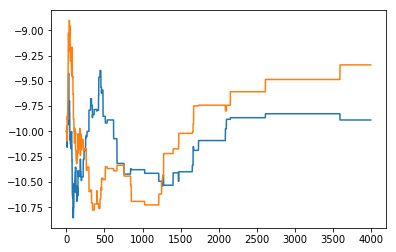

In [456]:
plt.plot(np.array(samples_mus)[:,1])

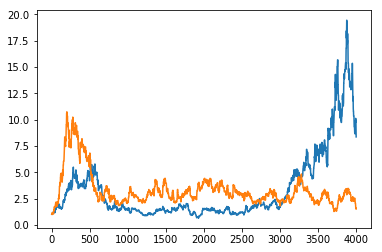

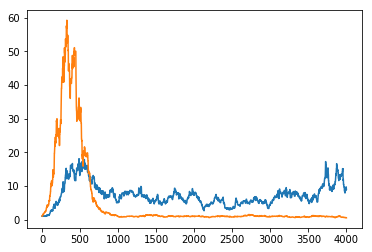

In [396]:
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,0,0])
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,1,1])

In [397]:
posterior_samples = posterior_samples[2000:]

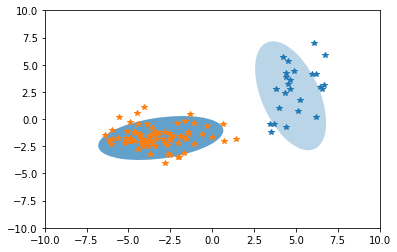

In [433]:
fig, ax = plt.subplots()
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')
for i in range(1):
    index = np.random.randint(len(posterior_samples))
    sample = posterior_samples[index]
    mus, sigmas, pis = sample[0], sample[1], sample[2]
    plot_gaussian(mus,sigmas,ax,pis)
    
plt.show()

In [382]:
samples

array([[ 5.25376301e+00,  7.41959325e+00],
       [ 5.43632133e+00,  1.78844386e+00],
       [ 7.21531225e+00,  3.87524463e+00],
       [ 5.57769982e+00,  7.37318911e-01],
       [ 4.70028621e+00,  9.35727964e-01],
       [ 4.39008600e+00,  4.69068283e+00],
       [ 6.98331713e+00, -7.76986072e-01],
       [ 5.30648041e+00,  4.01401220e+00],
       [ 3.90801794e+00,  4.23397214e+00],
       [ 4.08152317e+00,  3.91564312e+00],
       [ 5.68001541e+00,  4.47426930e+00],
       [ 4.38769674e+00,  5.13474419e+00],
       [ 5.58540342e+00,  2.52211282e+00],
       [ 5.48652080e+00,  5.41210283e+00],
       [ 6.32155880e+00,  7.71076940e+00],
       [ 6.26227205e+00,  2.20632650e+00],
       [ 5.26530499e+00,  1.88581915e+00],
       [ 4.05551137e+00,  4.11604455e+00],
       [ 4.26654055e+00,  3.68700494e+00],
       [ 4.44987256e+00,  2.83748984e+00],
       [ 4.68845182e+00,  2.19415601e+00],
       [ 5.52601439e+00, -2.17683160e-01],
       [ 3.66179426e+00,  1.42540319e+00],
       [ 5.